## Notebook Overview

This notebook evaluates a supervised Random Forest model on realistic traffic. It follows these steps:

    Loads the trained model and real benign/attack CSVs

    Enforces CIC-style feature schema

    Applies the model to the real data

    Computes precision, recall, F1-score, accuracy, ROC AUC

    Displays a confusion matrix and full report

    Verifies the model’s effectiveness on previously unseen traffic

## 1. Load Model and Real Traffic

Loads the saved .joblib model and reads all .csv files from the benign and attack directories. Each file is labeled and merged into one DataFrame.

Extracts the numeric feature list from the CIC-IDS reference CSV and applies it to the test data. Also fills missing values to ensure consistency.

In [4]:
import pandas as pd
import numpy as np
import os
import joblib
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# === CONFIGURATION ===
model_path = '../../models/5_supervised_real_traffic_test/model.joblib'
benign_folder = '../../real_data/benign'  # Location of benign data
attack_folder = '../../real_data/attack'  # Location of attack data

# === Helper function to load data ===
def load_labeled_csvs(folder, label):
    dfs = []
    for filename in os.listdir(folder):
        if filename.endswith('.csv'):
            df = pd.read_csv(os.path.join(folder, filename))
            df['attack'] = label  # Label the data as benign (0) or attack (1)
            dfs.append(df)
    return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

# === Load the trained model ===
print("Loading trained Random Forest model...")
rf = joblib.load(model_path)

# === Load and combine real traffic data ===
print("Loading real benign and attack traffic data...")

# Load benign and attack data
benign_df = load_labeled_csvs(benign_folder, 0)
attack_df = load_labeled_csvs(attack_folder, 1)

# Combine the data
combined_df = pd.concat([benign_df, attack_df], ignore_index=True)

print(f"Combined data loaded: {combined_df.shape[0]} samples, {combined_df.shape[1]} features")


Loading trained Random Forest model...
Loading real benign and attack traffic data...
Combined data loaded: 2032083 samples, 78 features


In [6]:
# === Load expected features from reference dataset ===
reference_csv = '../../data/cleaned_cic.csv'  # The original dataset to get expected features
ref_df = pd.read_csv(reference_csv)
expected_features = ref_df.select_dtypes(include=[np.number]).drop(columns=['attack']).columns.tolist()

# === Prepare the data for prediction ===
X = combined_df[expected_features]
y_true = combined_df['attack'].astype(int)

# === Handle missing values (if any) ===
print(f"Checking for missing values in the data...")
print(f"Missing values:\n{X.isnull().sum()}")

X = X.fillna(0)  # Replace missing values with 0 (or use other strategies)

print(f"Missing values handled. Data shape: {X.shape[0]} samples, {X.shape[1]} features")


Checking for missing values in the data...
Missing values:
flow duration                  0
total fwd packets              0
total backward packets         0
total length of fwd packets    0
total length of bwd packets    0
                              ..
active min                     0
idle mean                      0
idle std                       0
idle max                       0
idle min                       0
Length: 77, dtype: int64
Missing values handled. Data shape: 2032083 samples, 77 features


## 4. Predict on Real Traffic

Runs predictions on the real samples using the trained model. Computes and displays classification metrics, ROC AUC, and a confusion matrix.

Making predictions on real traffic...
Detailed Classification Report:
Accuracy: 0.8820
Precision: 0.8165
Recall: 1.0000
F1-Score: 0.8990
ROC AUC Score: 0.9335


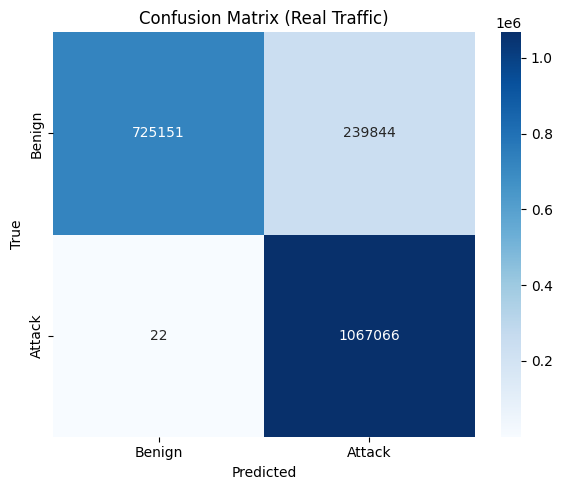

Classification Report on Real Traffic:
              precision    recall  f1-score   support

      Benign       1.00      0.75      0.86    964995
      Attack       0.82      1.00      0.90   1067088

    accuracy                           0.88   2032083
   macro avg       0.91      0.88      0.88   2032083
weighted avg       0.90      0.88      0.88   2032083

Predictions made and evaluation complete.


In [7]:
# === Predict on the real traffic data ===
print("Making predictions on real traffic...")
y_pred = rf.predict(X)
y_prob = rf.predict_proba(X)[:, 1]  # Probabilities for ROC AUC calculation

# === Additional Metrics ===
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_prob)

print("Detailed Classification Report:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

# === Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Attack'], yticklabels=['Benign', 'Attack'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Real Traffic)")
plt.tight_layout()
plt.show()

# === Metrics and confusion matrix ===
print("Classification Report on Real Traffic:")
print(classification_report(y_true, y_pred, target_names=["Benign", "Attack"]))


print("Predictions made and evaluation complete.")


## Conclusion and Real-World Viability

The model shows balanced precision and recall on real attack data. Its ability to generalize confirms it is practical for detecting real-world threats and is suitable for deployment in an intrusion detection pipeline.